In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from keras import backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight

## Read data from the dataset 

In [2]:
# Read images paths to dataframe

shape_mapping = {'diamond': 0, 'hex': 1, 'round': 2, 'square': 3, 'triangle': 4}
shape_data = {'Img Path': [], 'Class': []}

type_mapping = {'rightofway': 0, 'stop': 1, 'bicycle': 2, 'limitedtraffic': 3, 'noentry':4, 'noparking': 5, 'roundabout': 6, 'speed': 7, 'trafficdirective': 8, 'traveldirection': 9, 'continue': 10, 'crossing': 11, 'laneend': 12, 'parking': 13, 'giveway': 14, 'warning': 15}

type_data = {'Img Path': [], 'Class': []}


directory = ('./trafficsigns_dataset/trafficsigns_dataset/')
    
for item in os.listdir(directory):
    item_name = os.fsdecode(item)
    
    if not (os.path.isdir((os.path.join(directory, item_name)))):
        continue
    
    curr_path = os.path.join(directory, item_name)
    for sub_item in os.listdir(curr_path):
        type_name = os.fsdecode(sub_item)
        path = os.path.join(curr_path, sub_item)
        if not (os.path.isdir(path)):
            continue

        for img in os.listdir(path):
            temp = shape_data['Img Path']
            temp.append(os.path.join(path, img))
            shape_data['Img Path'] = temp
            type_data['Img Path'] = temp


            temp = shape_data['Class']
            temp.append(shape_mapping[item_name])
            shape_data['Class'] = temp

            temp = type_data['Class']
            temp.append(type_mapping[type_name])
            type_data['Class'] = temp
type_df = pd.DataFrame(data=type_data)
type_df['Class'] = type_df['Class'].astype('str')

<Axes: xlabel='Class', ylabel='count'>

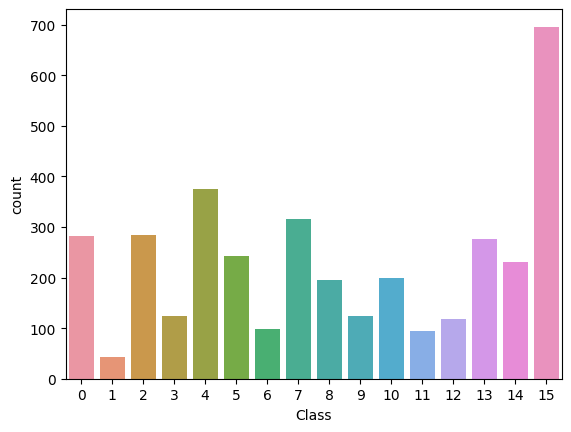

In [3]:
# Plot count for each class in dataset
sns.countplot(data=type_df, x='Class' )

## Base model 


In [4]:
# Set up baseline model structure
INPUT_DIM = (28,28,3)
HIDDEN_LAYER_DIM = 512
OUTPUT_CLASSES = 16
def baseline_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=INPUT_DIM),
        # Hidden layers
        tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid', kernel_regularizer=None),
        tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid', kernel_regularizer=None),
        tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid', kernel_regularizer=None),
        tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid', kernel_regularizer=None),
        # Output layers
        tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax')
    ])
    return model

## Convolutional Neural Network model 

In [5]:
# Set up CNN model structure 
reg_lambda = 0.002
model_leNet = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28, 28, 3)),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None)),
    
    # Convolutional layers
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    
    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    # Fully connected layers
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation = "softmax", kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])
model = model_leNet

#### CNN model visulaization 

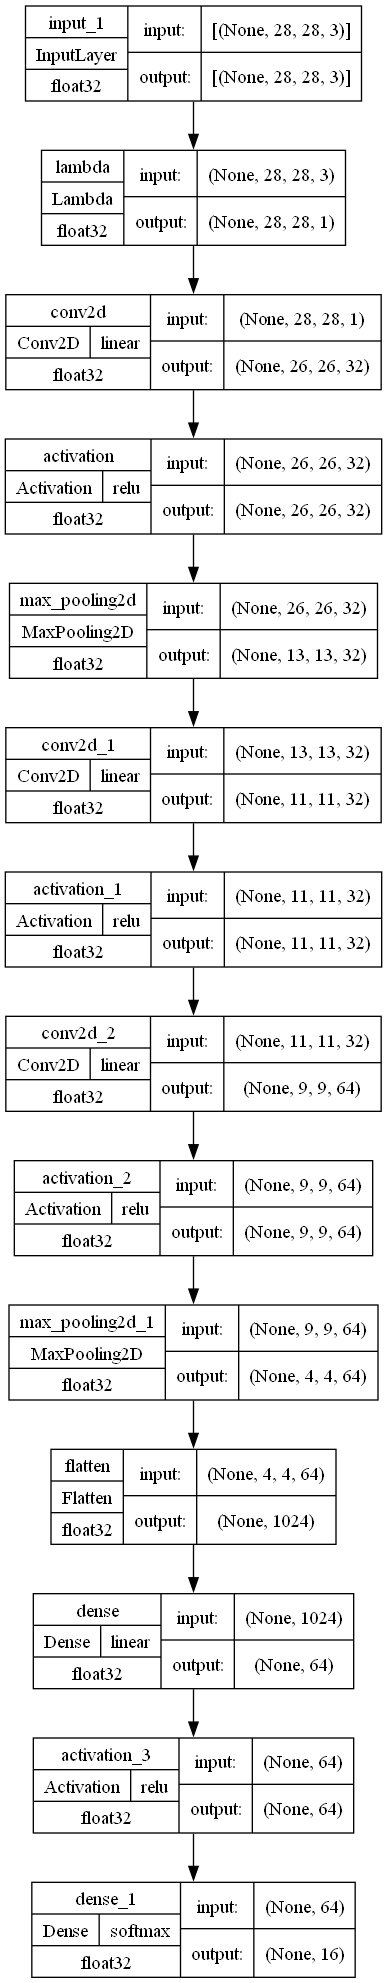

In [6]:
# plot CNN model structure
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, expand_nested=True, show_layer_activations=True, show_layer_names=True)

### Functions for results evaluation

In [7]:
# Define function for plotting model validation
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

In [8]:
# Manual calculation of F1 score
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


## Split data for training

In [9]:
# Data splitting
train_data, test_data = train_test_split(type_df, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)
train_data['Class'] = train_data['Class'].astype('str')
val_data['Class'] = val_data['Class'].astype('str')

## Train the model

In [10]:
# Generate image data for training and validation
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 20

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./',
        x_col="Img Path",
        y_col="Class",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./',
        x_col="Img Path",
        y_col="Class",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

Found 2220 validated image filenames belonging to 16 classes.
Found 740 validated image filenames belonging to 16 classes.


## Compile the model and evaluate

#### Fit and validate  using plot on baseline model

Epoch 1/50
111/111 [==============================] - 3s 18ms/step - loss: 2.6331 - f1_m: 0.0000e+00 - accuracy: 0.1842 - val_loss: 2.6295 - val_f1_m: 0.0000e+00 - val_accuracy: 0.1811
Epoch 2/50
111/111 [==============================] - 2s 14ms/step - loss: 2.5936 - f1_m: 0.0000e+00 - accuracy: 0.1928 - val_loss: 2.6428 - val_f1_m: 0.0000e+00 - val_accuracy: 0.1811
Epoch 3/50
111/111 [==============================] - 1s 12ms/step - loss: 2.5948 - f1_m: 0.0000e+00 - accuracy: 0.1937 - val_loss: 2.6366 - val_f1_m: 0.0000e+00 - val_accuracy: 0.1811
Epoch 4/50
111/111 [==============================] - 1s 12ms/step - loss: 2.5970 - f1_m: 0.0000e+00 - accuracy: 0.1919 - val_loss: 2.6254 - val_f1_m: 0.0000e+00 - val_accuracy: 0.1811
Epoch 5/50
111/111 [==============================] - 2s 14ms/step - loss: 2.6020 - f1_m: 0.0000e+00 - accuracy: 0.1937 - val_loss: 2.6289 - val_f1_m: 0.0000e+00 - val_accuracy: 0.1811
Epoch 6/50
111/111 [==============================] - 2s 16ms/step - loss: 

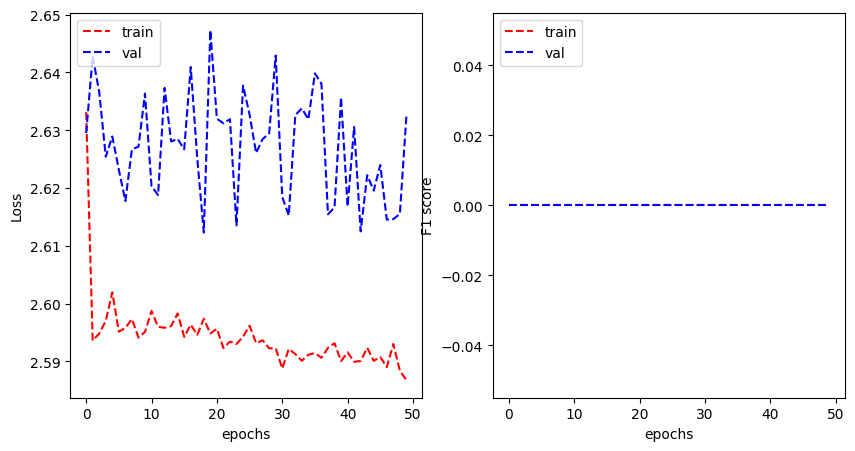

In [11]:
# Compile, fit and validate baseline model
baseline = baseline_model()
baseline.compile(optimizer=tf.optimizers.SGD(),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=[f1_m, "accuracy"],
              )
history = baseline.fit(train_generator, validation_data = validation_generator, epochs=50, verbose=1)

plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['f1_m'], history.history['val_f1_m'], 
                    metric_name='F1 score')

In [12]:
# Compute balanced class weights
weights = class_weight.compute_class_weight(class_weight='balanced', 
                                  classes = np.unique((train_data['Class'])), 
                                  y=train_data['Class'])
cls_wt = dict()
for i in range(len((weights))):
    cls_wt[i] = weights[i]

#### Compile, fit and validate on CNN model

In [13]:
# Compile CNN model
model.compile(optimizer=tf.optimizers.RMSprop(),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[f1_m, "accuracy"],
              )

In [14]:
# Fit CNN model
history = model.fit(train_generator, validation_data = validation_generator, epochs=50, verbose=1, class_weight=cls_wt)

Epoch 1/50


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


111/111 [==============================] - 3s 18ms/step - loss: 1.8586 - f1_m: 0.2755 - accuracy: 0.4622 - val_loss: 0.9141 - val_f1_m: 0.7245 - val_accuracy: 0.7541
Epoch 2/50
111/111 [==============================] - 2s 15ms/step - loss: 0.6210 - f1_m: 0.8202 - accuracy: 0.8514 - val_loss: 0.4150 - val_f1_m: 0.9182 - val_accuracy: 0.9297
Epoch 3/50
111/111 [==============================] - 2s 17ms/step - loss: 0.3870 - f1_m: 0.9137 - accuracy: 0.9261 - val_loss: 0.3433 - val_f1_m: 0.9280 - val_accuracy: 0.9351
Epoch 4/50
111/111 [==============================] - 2s 16ms/step - loss: 0.3041 - f1_m: 0.9361 - accuracy: 0.9419 - val_loss: 0.2691 - val_f1_m: 0.9573 - val_accuracy: 0.9608
Epoch 5/50
111/111 [==============================] - 2s 15ms/step - loss: 0.2327 - f1_m: 0.9557 - accuracy: 0.9581 - val_loss: 0.4524 - val_f1_m: 0.8947 - val_accuracy: 0.8946
Epoch 6/50
111/111 [==============================] - 2s 17ms/step - loss: 0.1989 - f1_m: 0.9648 - accuracy: 0.9671 - val_loss

#### Plot results for CNN model

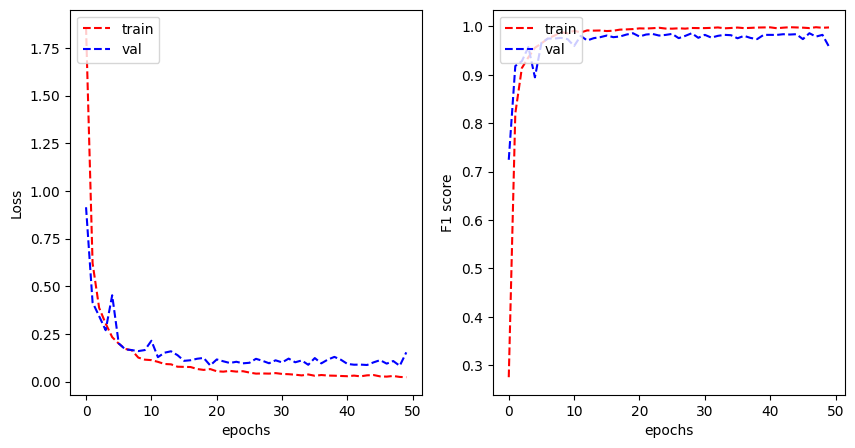

In [15]:
# Plot CNN model validation
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['f1_m'], history.history['val_f1_m'], 
                    metric_name='F1 score')

## Test on independent dataset 

In [16]:
# Read independent test data
shape_data = {'Img Path': [], 'Class': []}

type_mapping = {'rightofway': 0, 'stop': 1, 'bicycle': 2, 'limitedtraffic': 3, 'noentry':4, 'noparking': 5, 'roundabout': 6, 'speed': 7, 'trafficdirective': 8, 'traveldirection': 9, 'continue': 10, 'crossing': 11, 'laneend': 12, 'parking': 13, 'giveway': 14, 'warning': 15}

type_data = {'Img Path': [], 'Class': []}


directory = ('./test')
    
for item in os.listdir(directory):
    item_name = os.fsdecode(item)
    
    if not (os.path.isdir((os.path.join(directory, item_name)))):
        continue
    
    curr_path = os.path.join(directory, item_name)
    for sub_item in os.listdir(curr_path):
        type_name = os.fsdecode(sub_item)
        path = os.path.join(curr_path, sub_item)
        if not (os.path.isdir(path)):
            continue

        for img in os.listdir(path):
            temp = shape_data['Img Path']
            temp.append(os.path.join(path, img))
            shape_data['Img Path'] = temp
            type_data['Img Path'] = temp


            temp = shape_data['Class']
            temp.append(shape_mapping[item_name])
            shape_data['Class'] = temp

            temp = type_data['Class']
            temp.append(type_mapping[type_name])
            type_data['Class'] = temp
test_df = pd.DataFrame(data=type_data)
test_df['Class'] = test_df['Class'].astype('str')

In [17]:
# Generate test data
test_generator = val_datagen.flow_from_dataframe(
        dataframe=test_df,
        directory='./',
        x_col="Img Path",
        y_col="Class",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')


Found 460 validated image filenames belonging to 16 classes.


### Results of CNN model on test set 

In [18]:
# Evaluate test data on CNN
model.evaluate(test_generator, )

23/23 [==============================] - 2s 96ms/step - loss: 5.9431 - f1_m: 0.3898 - accuracy: 0.3891


[5.943137168884277, 0.3897968530654907, 0.3891304135322571]